# EDA and preprocessing of the azimuth adt dataset

In [43]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from lab_scripts.utils import utils
utils.change_directory_to_repo()
from lab_scripts.data.preprocessing.common import adt_normalization

sc.settings.verbosity = 3  # show info messages
sc.set_figure_params(figsize=(5, 3))  # set figsize for plots

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [28]:
adata_ADT = ad.read_h5ad("data/raw/gex_adt/azimuth_adt.h5ad")

## 1. Isotypic proteins counts per cell

Isotypic proteins are controls which do not target any human proteins and their expression should be considered background. 
<br>Here 4 rat proteins are observed. It is needed to relocate their matrix to another layes & remove them from adata.X and adata.var.

In [29]:
# Find rat proteins

protein_names = adata_ADT.var.index.tolist()

for i in range(len(protein_names)):
    if protein_names[i][0:2] == 'Ra':
        print(protein_names[i], '   Index:', i)
    else:
        continue

Rat-IgG1-1    Index: 1
Rat-IgG2b    Index: 19
Rat-IgG1-2    Index: 37
Rag-IgG2c    Index: 54


In [30]:
# Create df from sparse matrix
# Extract only columns with isoproteins from df
# Add columns to adata.obsm layer

isotype_df = pd.DataFrame.sparse.from_spmatrix(adata_ADT.X)
isotype_df.index = adata_ADT.obs.index
isotype_df.columns = adata_ADT.var.index

isotype_proteins = ['Rat-IgG1-1', 'Rat-IgG2b', 'Rat-IgG1-2', 'Rag-IgG2c']
isotype_df = isotype_df[isotype_proteins]
adata_ADT.obsm['isotype_controls'] = isotype_df

In [31]:
# Filter out isoproteins from adata.var
adata_ADT.var_filtered = adata_ADT.var.drop(index=isotype_proteins)

# Filter out isoproteins from adata.X
all_cols = np.arange(adata_ADT.X.shape[1])
cols_to_remove = [1, 19, 37, 54]
cols_to_keep = list(set(all_cols) - set(cols_to_remove))
adata_ADT.X_filtered = adata_ADT.X[:, cols_to_keep]

In [32]:
# Create new adata with no isoproteins beyond .obsm attribute

adata_ADT_new =  ad.AnnData(
    X = adata_ADT.X_filtered,
    var = adata_ADT.var_filtered,
    obs = adata_ADT.obs,
    uns = adata_ADT.uns,
    obsm = adata_ADT.obsm)

In [33]:
# Isoproteins count sum per cell
adata_ADT_new.obs['iso_count'] = np.asarray(np.sum(adata_ADT_new.obsm['isotype_controls'], axis = 1)).reshape(-1)
(adata_ADT_new.obs['iso_count'].min(), adata_ADT_new.obs['iso_count'].max())

(0.0, 2568.0)

Text(0, 0.5, 'Frequency')

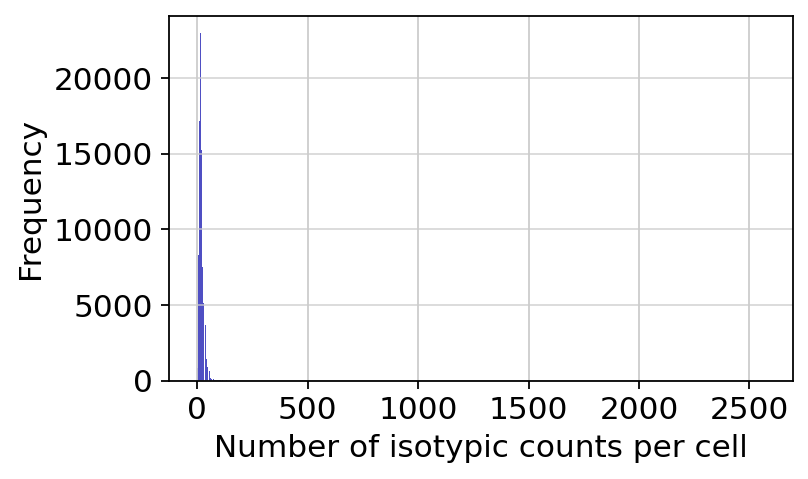

In [34]:
# Distribution for isotypic count sums per cell

n, bins, patches = plt.hist(x=adata_ADT_new.obs['iso_count'], bins=1000, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of isotypic counts per cell')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

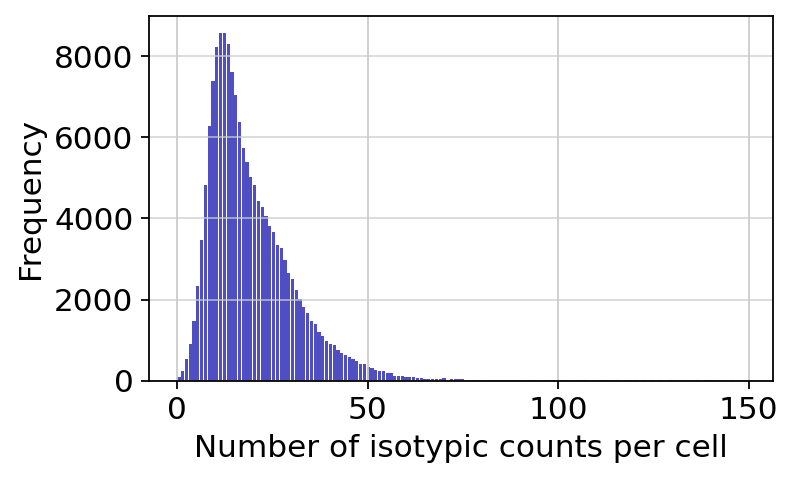

In [35]:
# Distribution for isotypic count sums per cell < 150

n, bins, patches = plt.hist(x=adata_ADT_new.obs['iso_count'][adata_ADT_new.obs['iso_count']<150], 
                            bins=150, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of isotypic counts per cell')
plt.ylabel('Frequency')

Range of isotypic counts under filtration in explore dataset is (1, 100) for 6 isoproteins
<br>Sum of counts in 4 isotypic proteins per cell. Here we have 4 proteins, so the proportion of 100 is ~67
<br>Thresholds should be (1, 67).

## 2. Total counts per cell

In [13]:
# ADT counts per cell

adata_ADT_new.obs['total_counts'] = np.asarray(np.sum(adata_ADT_new.X, axis = 1)).reshape(-1)
(adata_ADT_new.obs['total_counts'].min(), adata_ADT_new.obs['total_counts'].max())

(961.0, 49331.0)

[Text(0.5, 1.0, 'Histogram of number of counts per cell')]

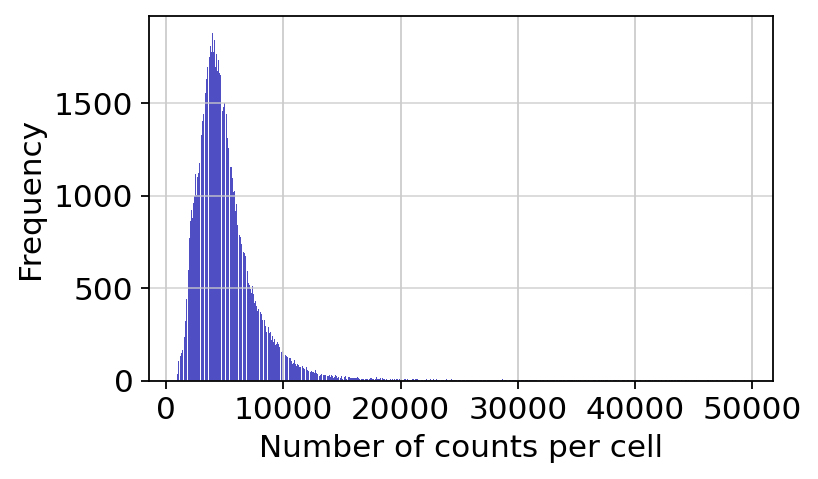

In [15]:
# Distribution for counts per cell

n, bins, patches = plt.hist(x=adata_ADT_new.obs['total_counts'], bins=1000, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of counts per cell')
plt.ylabel('Frequency')
plot.set(title='Histogram of number of counts per cell')

Text(0, 0.5, 'Frequency')

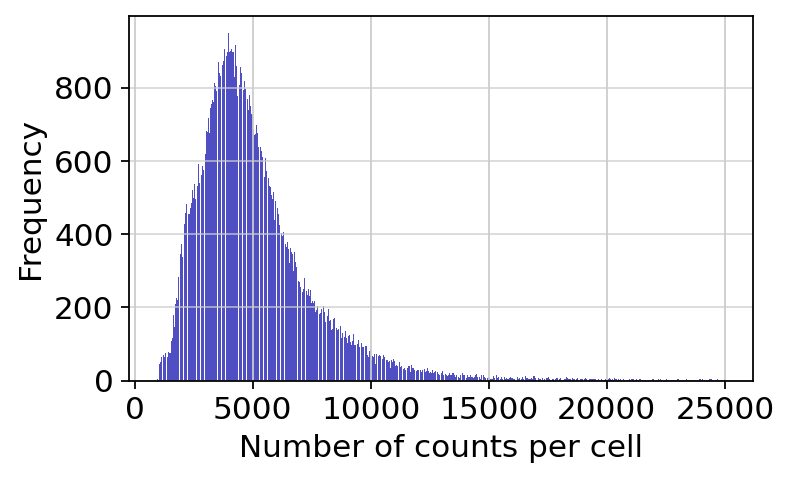

In [17]:
# Distribution for counts per cell < 25000
# 24000 is a threshold in explore dataset
# There is almost no counts at 24000 already

n, bins, patches = plt.hist(x=adata_ADT_new.obs['total_counts'][adata_ADT_new.obs['total_counts']<25000], 
                            bins=1000, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of counts per cell')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

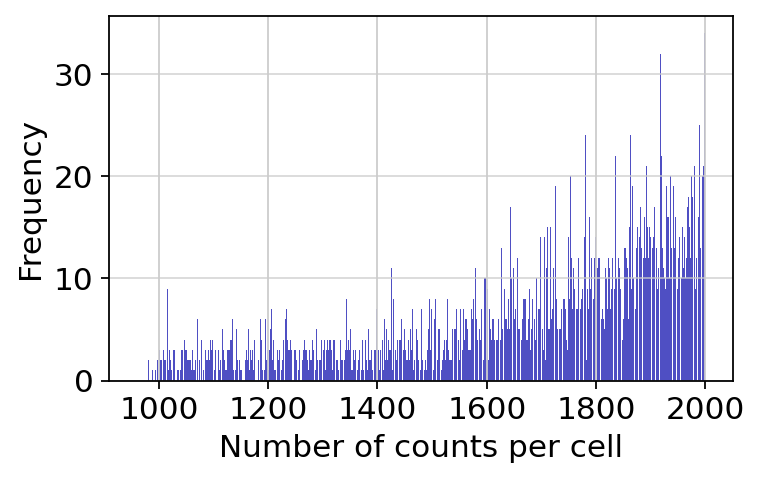

In [18]:
# Distribution for counts per cell < 2000
# 956 is minimal value out of all cells

n, bins, patches = plt.hist(x=adata_ADT_new.obs['total_counts'][adata_ADT_new.obs['total_counts']<2000], 
                            bins=1000, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of counts per cell')
plt.ylabel('Frequency')

Thresholds chosen by authors are (1100, 24000).
<br>We can take the same ones. Even though the number of proteins in this dataset is larger, there is no need to choose higher upper threshold as there is already almost no counts at 24000 point.

## 3. Proteins per cell

In [37]:
# Number of proteins per cell
# Total number = 228

adata_ADT_new.obs['n_antibodies_by_counts'] = np.asarray((adata_ADT_new.X > 0).sum(axis=1)).reshape(-1)
(adata_ADT_new.obs['n_antibodies_by_counts'].min(), adata_ADT_new.obs['n_antibodies_by_counts'].max())

(103, 224)

[Text(0.5, 1.0, 'Histogram of detected ADTs per cell')]

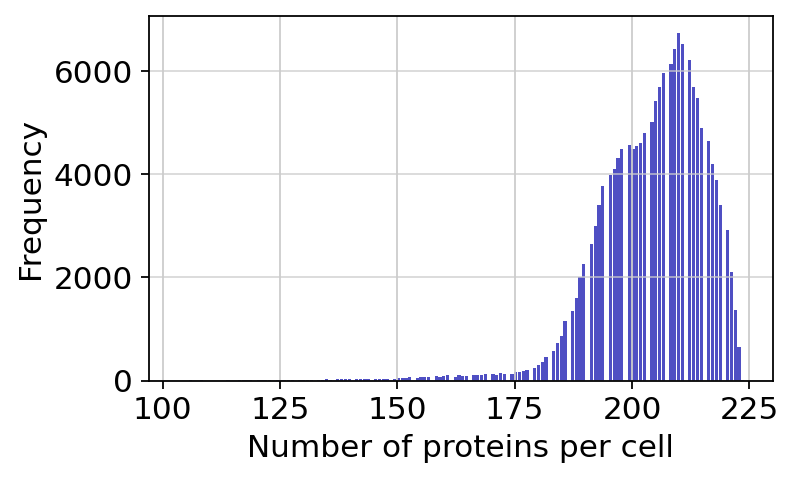

In [39]:
# Distribution for proteins per cell
# total_number*0.6 is a threshold in explore dataset
# Here it is equal to 134 proteins. Almost all cells have more proteins per cell that 134.

n, bins, patches = plt.hist(x=adata_ADT_new.obs['n_antibodies_by_counts'], bins=150, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of proteins per cell')
plt.ylabel('Frequency')
plot.set(title='Histogram of detected ADTs per cell')

Text(0, 0.5, 'Frequency')

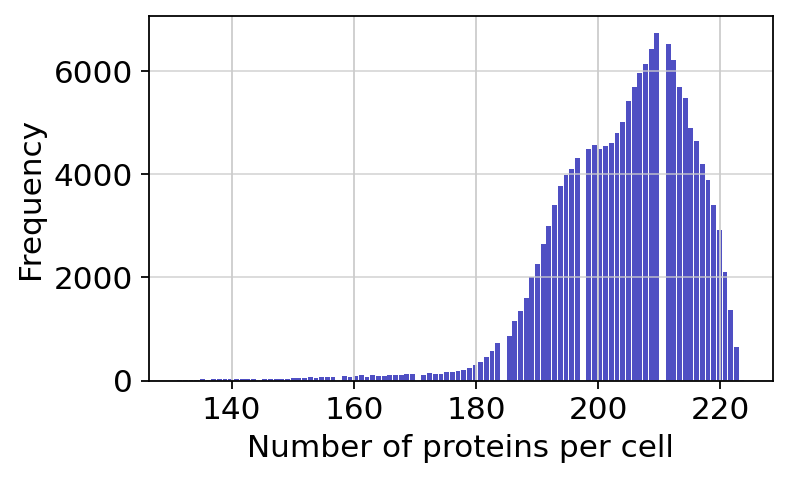

In [40]:
# I would take 170 as a threshold. 134 seems not enough strict

n, bins, patches = plt.hist(
    x=adata_ADT_new.obs['n_antibodies_by_counts'][adata_ADT_new.obs['n_antibodies_by_counts']>130],
    bins=100, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of proteins per cell')
plt.ylabel('Frequency')

## 4. After normalization

In [41]:
# Reimplemented in Python

def CLR_transform(sparse):
    array = sparse.toarray()
    logn1 = np.log(array+1)
    mean = np.nanmean(logn1, axis = 1)
    exponent = np.exp(mean)
    ratio = (array/exponent[:,None]) + 1
    T_clr = np.log(ratio)
    transformed = csr_matrix(T_clr)
    return transformed

In [44]:
# Perform centre log ratio (CLR) transformation
# Store transformed data in adata.X and convert from numpy to sparse matrix

adata_ADT_new.X = CLR_transform(adata_ADT_new.X)

[Text(0.5, 1.0, 'Normalized of number of counts per cell')]

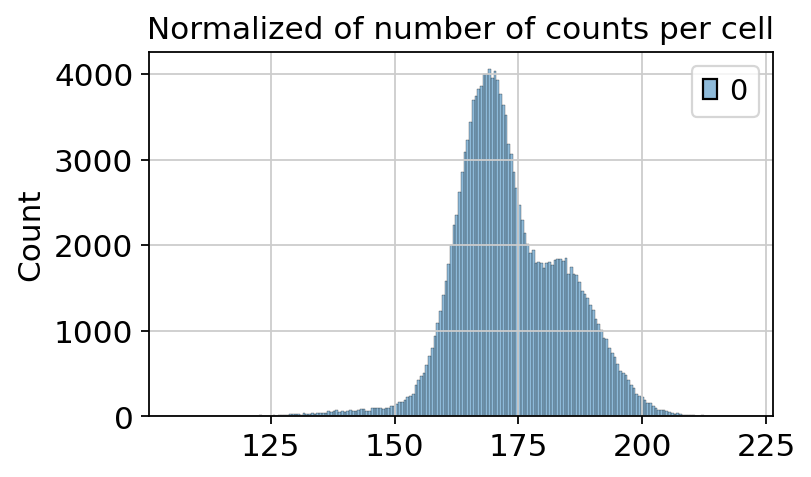

In [45]:
plot = sns.histplot(adata_ADT_new.X.sum(axis=1))
plot.set(title='Normalized of number of counts per cell')

Only positive numbers are observed which looks like Seurat modification of CLR transform.